<a href="https://colab.research.google.com/github/BoopeshMohanraj/Sentimen-analysis-on-NYSE-JPM-using-python/blob/main/JPM_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install yfinance newsapi-python vaderSentiment fredapi requests beautifulsoup4 nltk --quiet


In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use('seaborn-v0_8-whitegrid')

In [50]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [51]:
def fetch_finviz_news(ticker="JPM"):
    """
    Scrape Finviz.com for the given ticker’s latest news headlines.
    Returns a DataFrame: [Date, Headline].
    """
    url = f"https://finviz.com/quote.ashx?t={ticker}"
    headers = {"User-Agent": "Mozilla/5.0"}
    resp = requests.get(url, headers=headers)
    soup = BeautifulSoup(resp.text, "html.parser")

    news_table = soup.find("table", class_="fullview-news-outer")
    if not news_table:
        return pd.DataFrame(columns=["Date", "Headline"])

    rows = news_table.findAll("tr")
    parsed_news = []

    for row in rows:
        date_col = row.findAll("td")[0].text.strip()
        headline = row.findAll("td")[1].text.strip()

        split_data = date_col.split()
        if "Today" in date_col or len(split_data) == 1:

            date_parsed = datetime.today().date()
        else:

            date_str = split_data[0]
            try:
                date_parsed = datetime.strptime(date_str, "%b-%d-%y").date()
            except:
                continue

        parsed_news.append({"Date": date_parsed, "Headline": headline})

    return pd.DataFrame(parsed_news)


In [52]:
start_date = "2025-02-01"
end_date   = "2025-03-01"

stock_data = yf.download("JPM", start=start_date, end=end_date)
# Flatten columns if there's a MultiIndex :
stock_data.columns = stock_data.columns.to_flat_index()

# Convert the column tuples into simpler names
stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in stock_data.columns]

# Reset the index so that "Date" is a normal column
stock_data.reset_index(inplace=True)

print("Raw Stock Data:")
display(stock_data.head(15))
display(stock_data.tail(10))

[*********************100%***********************]  1 of 1 completed

Raw Stock Data:


,Date,Close,High,Low,Open,Volume
0,2025-02-03,266.809998,268.170013,261.700012,261.829987,8381400
1,2025-02-04,267.940002,269.839996,266.829987,269.839996,5626000
2,2025-02-05,270.429993,270.640015,268.329987,268.910004,5704400
3,2025-02-06,276.899994,276.980011,271.190002,272.450012,7264400
4,2025-02-07,275.799988,278.549988,274.709991,277.269989,6857900
5,2025-02-10,271.040009,276.179993,269.589996,276.149994,8627400
6,2025-02-11,274.989990,276.220001,269.660004,270.260010,7196400
7,2025-02-12,275.450012,276.450012,273.250000,274.079987,6683900
8,2025-02-13,276.320007,276.970001,273.809998,275.500000,8398700
9,2025-02-14,276.589996,279.230011,276.450012,277.369995,5688600


,Date,Close,High,Low,Open,Volume
9,2025-02-14,276.589996,279.230011,276.450012,277.369995,5688600
10,2025-02-18,279.950012,279.970001,276.019989,276.760010,7919800
11,2025-02-19,279.250000,280.250000,277.220001,278.380005,7007200
12,2025-02-20,266.799988,278.739990,265.739990,278.679993,13846700
13,2025-02-21,264.239990,269.200012,262.839996,268.320007,12835600
14,2025-02-24,261.339996,267.000000,258.609985,265.489990,10372800
15,2025-02-25,257.399994,263.000000,253.350006,262.230011,9608400
16,2025-02-26,258.790009,260.910004,256.929993,257.160004,5943600
17,2025-02-27,259.049988,263.640015,257.859985,260.179993,8204400
18,2025-02-28,264.649994,264.809998,257.890015,260.730011,10467100


In [53]:
raw_news = fetch_finviz_news("JPM")
raw_news["Date"] = pd.to_datetime(raw_news["Date"])

# Filter only for headlines within Feb 2025
mask = (raw_news["Date"] >= pd.to_datetime("2025-02-01")) & \
       (raw_news["Date"] < pd.to_datetime("2025-03-01"))
raw_news = raw_news.loc[mask].copy()

print("Raw News Headlines (Feb 2025):")
display(raw_news.head(30))
display(raw_news.tail(30))

<ipython-input-51-113756b9e0db>:15: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  rows = news_table.findAll("tr")
<ipython-input-51-113756b9e0db>:19: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  date_col = row.findAll("td")[0].text.strip()  # e.g. "Feb-05-25 10:00AM" or "Today 11:00AM"
<ipython-input-51-113756b9e0db>:20: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  headline = row.findAll("td")[1].text.strip()


Raw News Headlines (Feb 2025):


,Date,Headline
31,2025-02-28,Is JPMorgan Chase & Co. (JPM) the Best Afforda...
38,2025-02-27,Lose Your Job Following Trump's Government Pur...
41,2025-02-26,JPMorgan Chase & Co. (JPM): One of the Top Div...
46,2025-02-25,Analyst Report: JPMorgan Chase & Co.\n\n\n(Mor...
58,2025-02-24,Jamie Dimon doubles down on RTO plans after te...
69,2025-02-23,The U.S. Economy Depends More Than Ever on Ric...
72,2025-02-21,DEI retreat widens as Citigroup and PepsiCo ro...
74,2025-02-20,"JPMorgan had 'buyer's remorse,' lawyer says as..."
82,2025-02-19,JPMorgan Chase & Co. (JPM) Stock Sinks As Mark...
89,2025-02-18,JPMorgan Offers Details on CEO Jamie Dimons Ne...


,Date,Headline
31,2025-02-28,Is JPMorgan Chase & Co. (JPM) the Best Afforda...
38,2025-02-27,Lose Your Job Following Trump's Government Pur...
41,2025-02-26,JPMorgan Chase & Co. (JPM): One of the Top Div...
46,2025-02-25,Analyst Report: JPMorgan Chase & Co.\n\n\n(Mor...
58,2025-02-24,Jamie Dimon doubles down on RTO plans after te...
69,2025-02-23,The U.S. Economy Depends More Than Ever on Ric...
72,2025-02-21,DEI retreat widens as Citigroup and PepsiCo ro...
74,2025-02-20,"JPMorgan had 'buyer's remorse,' lawyer says as..."
82,2025-02-19,JPMorgan Chase & Co. (JPM) Stock Sinks As Mark...
89,2025-02-18,JPMorgan Offers Details on CEO Jamie Dimons Ne...


In [54]:
stop_words = set(stopwords.words("english"))
analyzer = SentimentIntensityAnalyzer()

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Keep only alphabetic & exclude stopwords
    tokens = [w.lower() for w in tokens if w.isalpha() and w.lower() not in stop_words]
    return " ".join(tokens)

def get_sentiment_score(text):
    vs = analyzer.polarity_scores(text)
    return vs["compound"]  # Range: -1 (negative) to +1 (positive)


In [55]:
# Group by date (daily), take mean of all headlines' sentiment
aggregated_sentiment = (
    news_data
    .groupby(news_data["Date"].dt.date)["sentiment_score"]
    .mean()
    .reset_index()
)

aggregated_sentiment.columns = ["Date", "aggregated_sentiment_score"]
print("Aggregated Sentiment by Date:")
display(aggregated_sentiment)


Aggregated Sentiment by Date:


,Date,aggregated_sentiment_score
0,2025-02-16,0.6369
1,2025-02-17,0.0000
2,2025-02-18,0.0000
3,2025-02-19,0.3400
4,2025-02-20,-0.2732
5,2025-02-21,0.2023
6,2025-02-23,0.5574
7,2025-02-24,-0.3400
8,2025-02-25,0.0000
9,2025-02-26,0.2023


In [56]:
# Convert the stock_data date column to a plain date
stock_data["Date"] = pd.to_datetime(stock_data["Date"]).dt.date

# Convert aggregated_sentiment's Date to plain date as well
aggregated_sentiment["Date"] = pd.to_datetime(aggregated_sentiment["Date"]).dt.date

# Merge on 'Date'
combined_data = pd.merge(stock_data, aggregated_sentiment, on="Date", how="inner")

print("Merged Stock + Sentiment Data:")
display(combined_data)


Merged Stock + Sentiment Data:


,Date,Close,High,Low,Open,Volume,aggregated_sentiment_score
0,2025-02-18,279.950012,279.970001,276.019989,276.760010,7919800,0.0000
1,2025-02-19,279.250000,280.250000,277.220001,278.380005,7007200,0.3400
2,2025-02-20,266.799988,278.739990,265.739990,278.679993,13846700,-0.2732
3,2025-02-21,264.239990,269.200012,262.839996,268.320007,12835600,0.2023
4,2025-02-24,261.339996,267.000000,258.609985,265.489990,10372800,-0.3400
5,2025-02-25,257.399994,263.000000,253.350006,262.230011,9608400,0.0000
6,2025-02-26,258.790009,260.910004,256.929993,257.160004,5943600,0.2023
7,2025-02-27,259.049988,263.640015,257.859985,260.179993,8204400,-0.4019
8,2025-02-28,264.649994,264.809998,257.890015,260.730011,10467100,0.6369


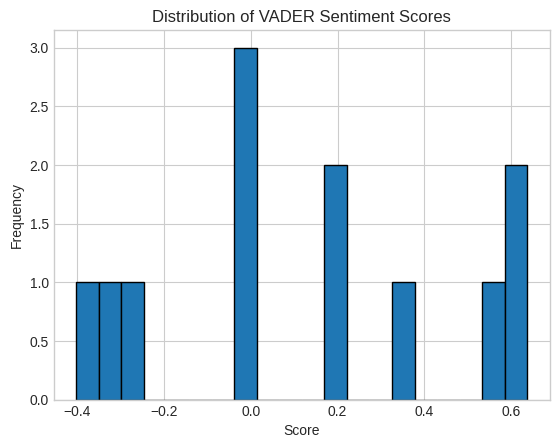

In [57]:
plt.hist(news_data["sentiment_score"], bins=20, edgecolor="black")
plt.title("Distribution of VADER Sentiment Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


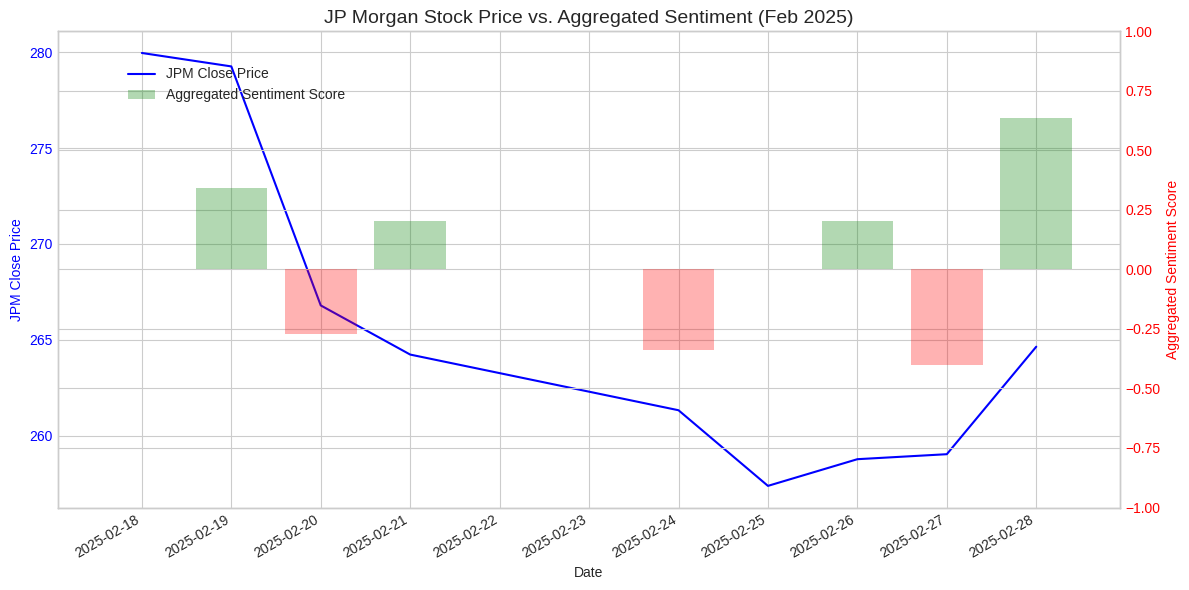

In [58]:
# Convert combined_data["Date"] back to datetime for plotting
combined_data["Date"] = pd.to_datetime(combined_data["Date"])
combined_data.sort_values("Date", inplace=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Stock Price (Line)
ax1.set_xlabel("Date")
ax1.set_ylabel("JPM Close Price", color='blue')
ax1.plot(combined_data["Date"], combined_data["Close"], color='blue', label="JPM Close Price")
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis for daily dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # show every day (adjust if you want fewer ticks)
fig.autofmt_xdate()  # rotate date labels

# Aggregated Sentiment (Bars)
ax2 = ax1.twinx()  # second y-axis
ax2.set_ylabel("Aggregated Sentiment Score", color='red')
bar_colors = ['green' if val >= 0 else 'red' for val in combined_data["aggregated_sentiment_score"]]

ax2.bar(
    combined_data["Date"],
    combined_data["aggregated_sentiment_score"],
    color=bar_colors,
    alpha=0.3,
    width=0.8,
    label="Aggregated Sentiment Score"
)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(-1, 1)  # typical VADER range

plt.title("JP Morgan Stock Price vs. Aggregated Sentiment (Feb 2025)", fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()
